## Evaluation Heatmap
Using the outside-model scaling, and best STD for each dataset, replication of Nettekoven2024 has been done

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

### Loading avg and loo models

In [9]:
method = 'L2reg'
train_ds_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]#, "Fusion"]
eval_ds_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
df_all = pd.DataFrame()
for dataset_name in train_ds_list:
    eval_data = [ev_ds if ev_ds != "Language" else "Languagelocalizer" for ev_ds in eval_ds_list]
    eval_data = [ev_ds if ev_ds != "HCPur100" else "HCPur100task" for ev_ds in eval_data]

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-Cavg"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-Cavg"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer'],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

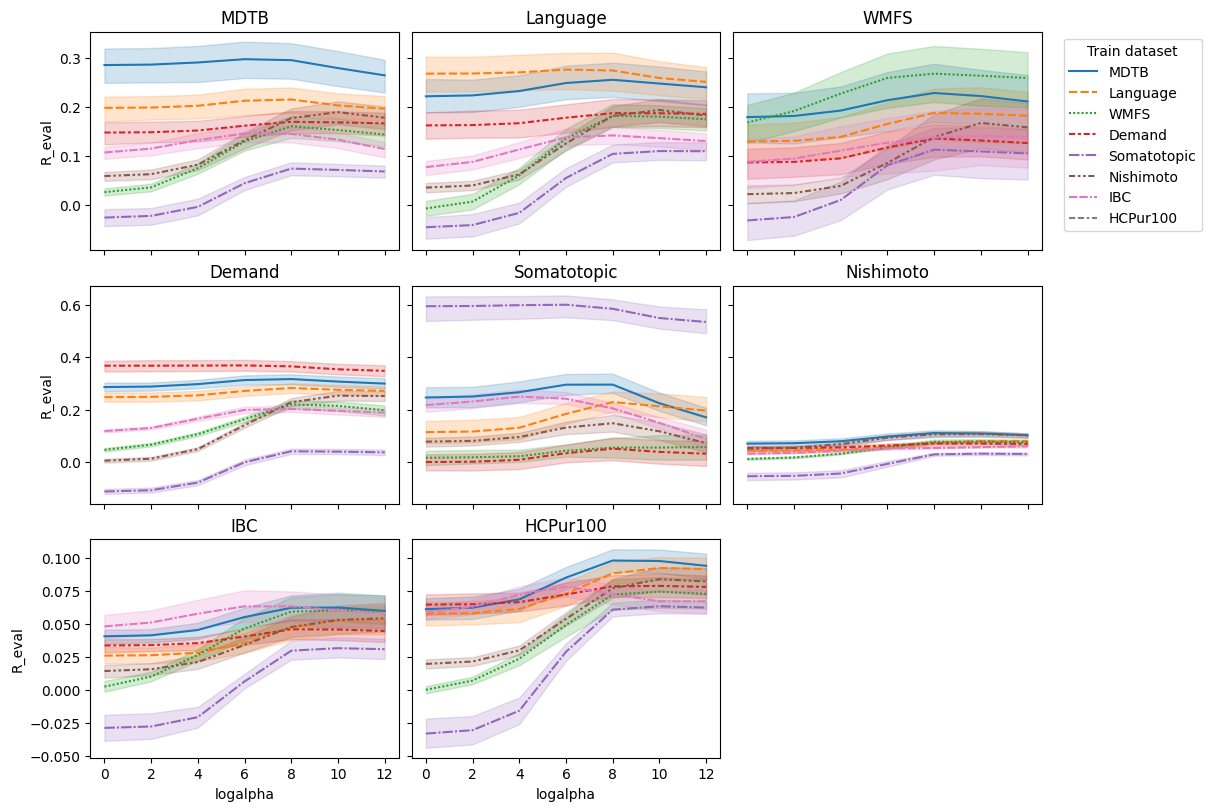

In [10]:
fig, axes = plt.subplots(np.ceil(len(eval_ds_list) / 3).astype(int), 3, figsize=(12, 8), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax = axes[i // 3, i % 3]
    df_to_plot = df_all[(df_all.eval_dataset==ed) & ((df_all.train_dataset!=ed)
                                                     | (df_all.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=eval_ds_list, style_order=eval_ds_list, ax=ax)
    ax.set_title(ed)

    if i == 2:
        ax.legend(title='Train dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove()

# Remove extra subplots if more than len(eval_ds_list)
if len(eval_ds_list) < axes.size:
    for j in range(len(eval_ds_list), axes.size):
        fig.delaxes(axes.flatten()[j])

### Find best hyperparameter

In [11]:
A = pd.pivot_table(df_all, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.176538  0.178115  0.185834  0.201300  0.208682  0.199458   
Language       0.146577  0.147325  0.151919  0.166916  0.179635  0.175839   
WMFS           0.030376  0.042541  0.072221  0.113583  0.144711  0.142535   
Demand         0.148568  0.149011  0.151665  0.159867  0.166168  0.162658   
Somatotopic   -0.021149 -0.017601  0.002381  0.056237  0.089042  0.087926   
Nishimoto      0.027403  0.031129  0.049526  0.097577  0.142619  0.154718   
IBC            0.089001  0.096536  0.115025  0.130330  0.129146  0.121430   

                         
logalpha           12.0  
train_dataset            
MDTB           0.189875  
Language       0.171766  
WMFS           0.136141  
Demand         0.159781  
Somatotopic    0.085368  
Nishimoto      0.148087  
IBC            0.113248

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
WMFS,8.0
Demand,8.0
Somatotopic,8.0
Nishimoto,10.0
IBC,6.0


### Evaluation Heatmap at best Hyperparameter

Text(45.72222222222221, 0.5, 'Eval Dataset')

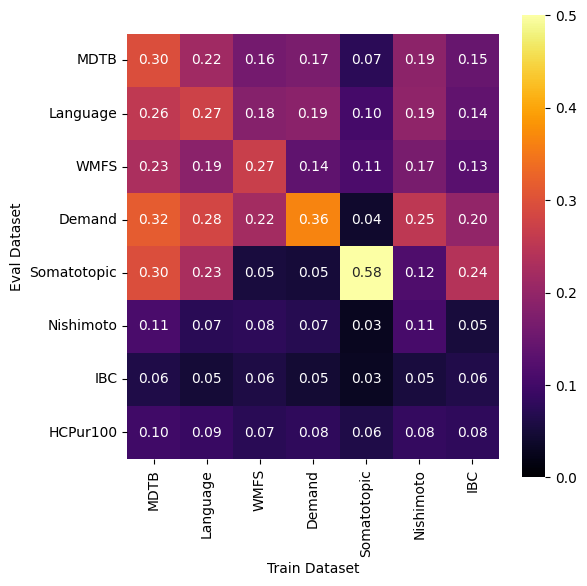

In [12]:
plt.figure(figsize=(6,6))

df_to_plot = df_all[df_all.isbest].reset_index(drop=True)
V = pd.pivot_table(df_to_plot, columns='train_dataset', index='eval_dataset', values='R_eval')
V = V.reindex(eval_ds_list, axis=0)
V = V.reindex(train_ds_list, axis=1)

sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.5, 
            xticklabels=V.columns.values, 
            yticklabels=V.index.values, square=True)
plt.xlabel('Train Dataset')
plt.ylabel('Eval Dataset')

### Evaluation on HCP-task

Text(0.5, 1.0, 'Average performance of datasets on HCP-task (avg cortical)')

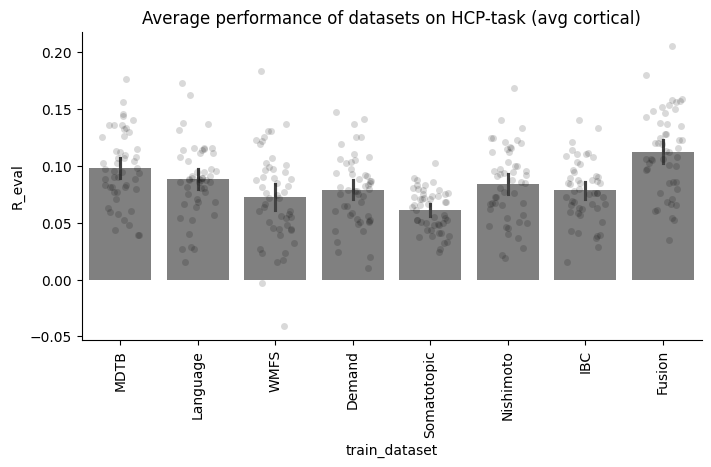

In [7]:
# Add Fusion model
df_fuse = rm.comb_eval(models=["Fusion-Cavg"], methods=[method], eval_data=["HCPur100task"], cerebellum='MNISymC3')
df_on_HCP = df_all[(df_all['eval_dataset'] == 'HCPur100') & (df_all['isbest'])].reset_index(drop=True)
df_on_HCP = pd.concat([df_on_HCP, df_fuse], ignore_index=True)

plt.figure(figsize=(8, 4))
sns.barplot(data=df_on_HCP, x='train_dataset', y='R_eval', order=train_ds_list+["Fusion"], color=[0.5,0.5,0.5])
sns.stripplot(data=df_on_HCP, x='train_dataset', y='R_eval', color=[0,0,0], alpha=0.15, jitter=0.25)
ax = plt.gca()
ax.set_xticks(np.arange(len(train_ds_list+["Fusion"])))
a = ax.set_xticklabels(train_ds_list+["Fusion"], rotation=90)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Average performance of datasets on HCP-task (avg cortical)')